In [1]:
import sys, os
sys.path.append(os.path.abspath("src"))

In [ ]:
# setup & imports

import os
from pprint import pprint

# Make sure we can import from src/
import sys
sys.path.append(os.path.abspath("src"))
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from src.workflows.meta_workflow import build_meta_graph
from src.workflows.user_workflow import build_user_analytics_graph
from src.workflows.phase2_qna_workflow import build_qna_graph

from pathlib import Path

def clear_all_plots(plot_dir: str = "plots"):
    """Delete all existing PNG files in the plots folder so we always use fresh ones."""
    p = Path(plot_dir)
    if not p.exists():
        return

    removed = 0
    for png in p.glob("*.png"):
        try:
            png.unlink()
            removed += 1
        except Exception as e:
            print(f"Could not delete {png}: {e}")
    print(f"Cleared {removed} old plot(s) from '{plot_dir}'.")

clear_all_plots("plots")


Cleared 15 old plot(s) from 'plots'.


In [ ]:
# run Phase 0 (META) once

meta_graph = build_meta_graph()

print("=== RUNNING META WORKFLOW (PHASE 0) ===")
meta_state = meta_graph.invoke({}, config={"recursion_limit": 80})

print("Meta state keys:", list(meta_state.keys()))
print("Meta summary:")
pprint(meta_state.get("meta_analytics", {}).get("summary", {}))
print("\n meta_llm_tables keys:")
print(list(meta_state.get("meta_llm_tables", {}).keys()))


=== RUNNING META WORKFLOW (PHASE 0) ===
Meta state keys: ['top_players', 'selected_players', 'used_player_indices', 'fetched_player_tags', 'meta_raw_battles', 'normalized_battles', 'meta_analytics', 'is_balanced', 'loop_count', 'stop_decision', 'notes', 'meta_table', 'meta_llm_tables']
Meta summary:
{'draws': 6,
 'games_played': 2116,
 'losses': 852,
 'win_rate': 0.5945179584120983,
 'wins': 1258}

 meta_llm_tables keys:
['meta_deck_summary', 'meta_matchup_summary']


In [ ]:
# run Phase 1 (USER) once

user_graph = build_user_analytics_graph()

# You can change this to another tag (your)
player_tag = os.getenv("PLAYER_TAG", "8C8JJQLG")

print("=== RUNNING USER WORKFLOW (PHASE 1) ===")
user_state = user_graph.invoke({"player_tag": player_tag})

print("User state keys:", list(user_state.keys()))
print("User summary:")
pprint(user_state.get("user_analytics", {}).get("summary", {}))

print("\n user_llm_tables keys:")
print(list(user_state.get("user_llm_tables", {}).keys()))


=== RUNNING USER WORKFLOW (PHASE 1) ===
User state keys: ['player_tag', 'battles_raw', 'battles_filtered', 'user_analytics', 'user_llm_tables', 'user_plots', 'notes']
User summary:
{'draws': 0,
 'games_played': 18,
 'losses': 12,
 'win_rate': 0.3333333333333333,
 'wins': 6}

 user_llm_tables keys:
['user_summary', 'user_deck_summary', 'user_matchup_summary', 'user_card_summary', 'opponent_card_summary']



   Phase 0: Meta plots

meta_deck_types_winrate.png


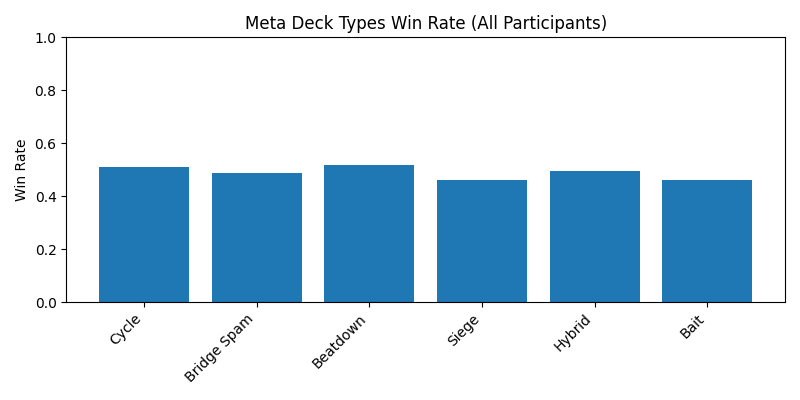


meta_deck_types.png


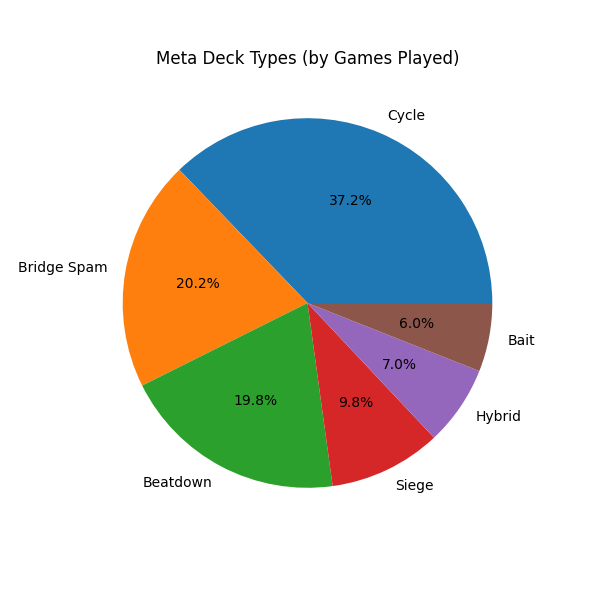


meta_matchups_bait.png


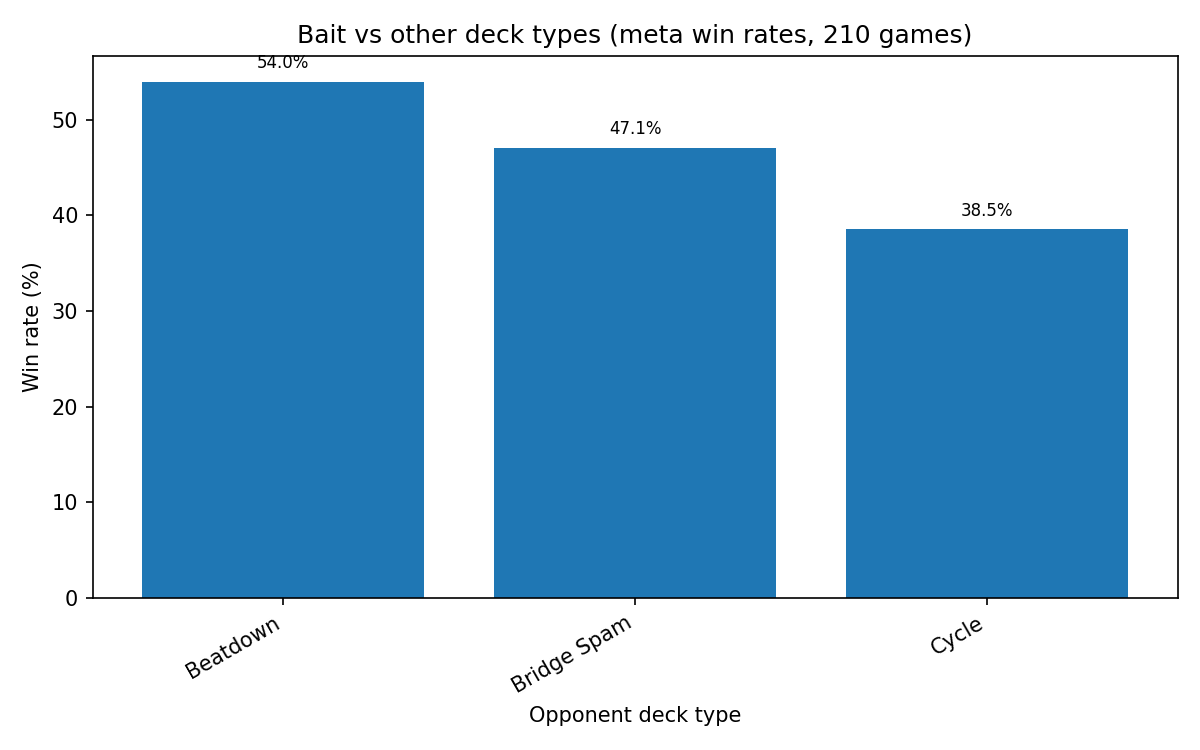


meta_matchups_beatdown.png


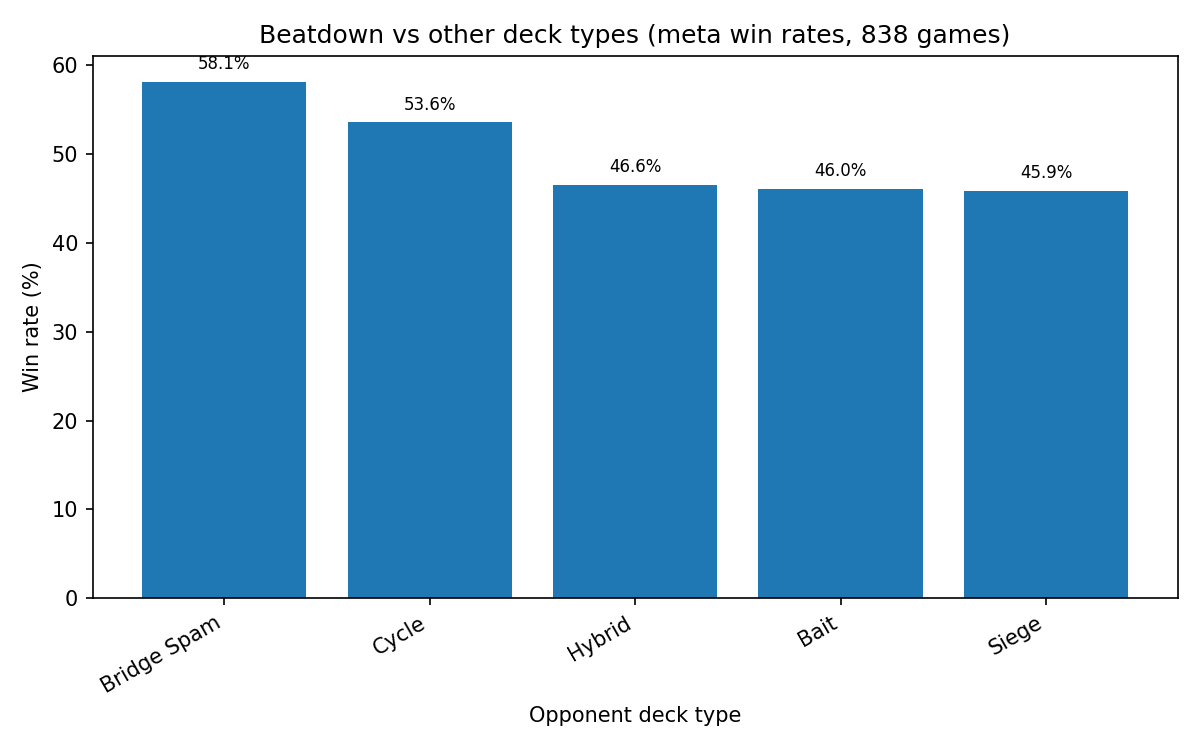


meta_matchups_bridge_spam.png


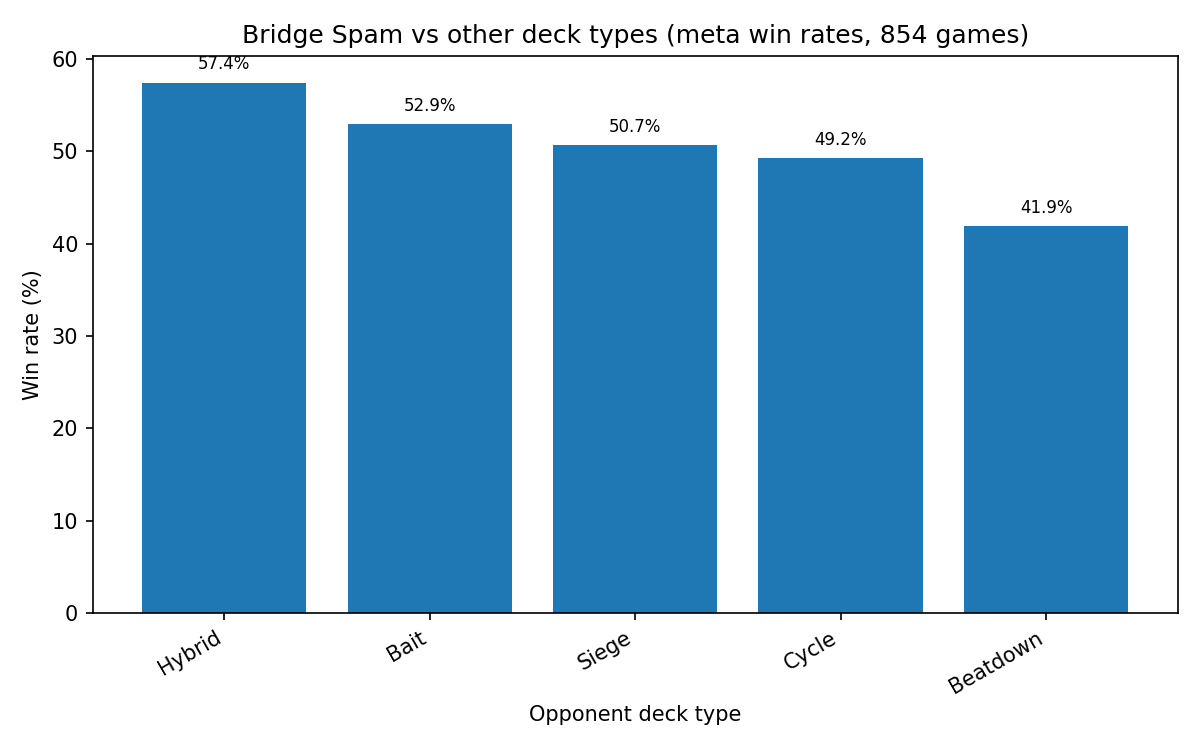


meta_matchups_cycle.png


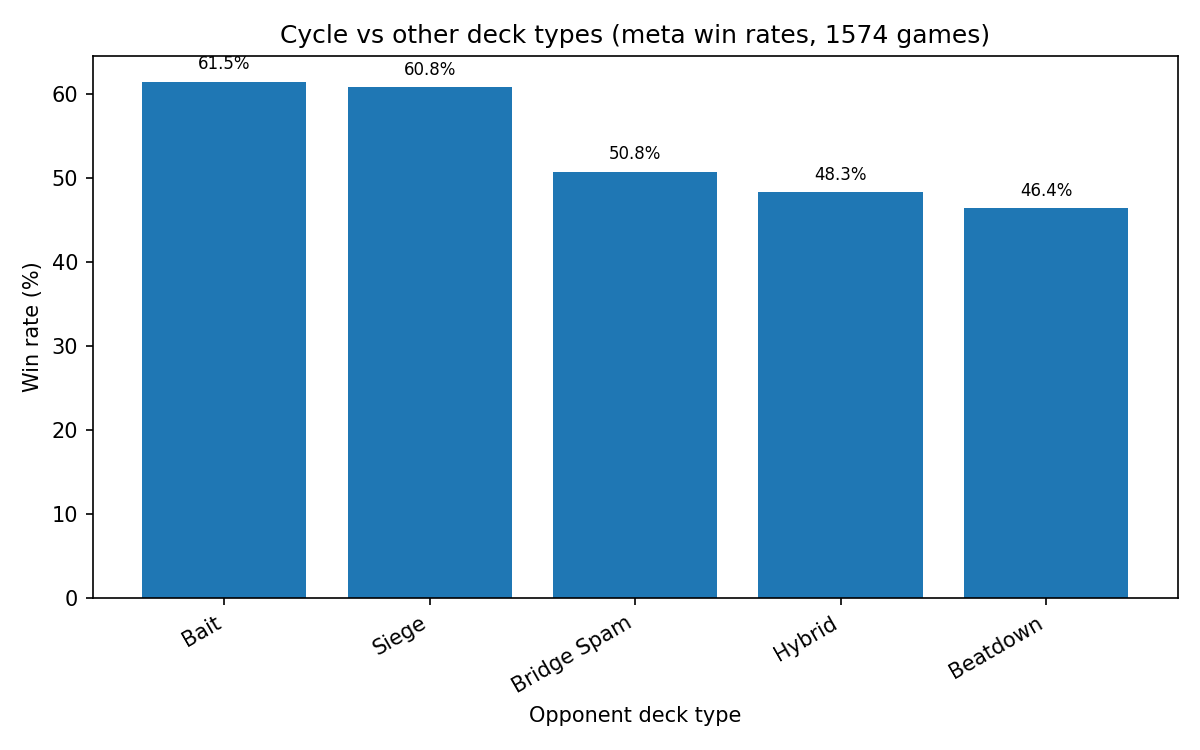


meta_matchups_hybrid.png


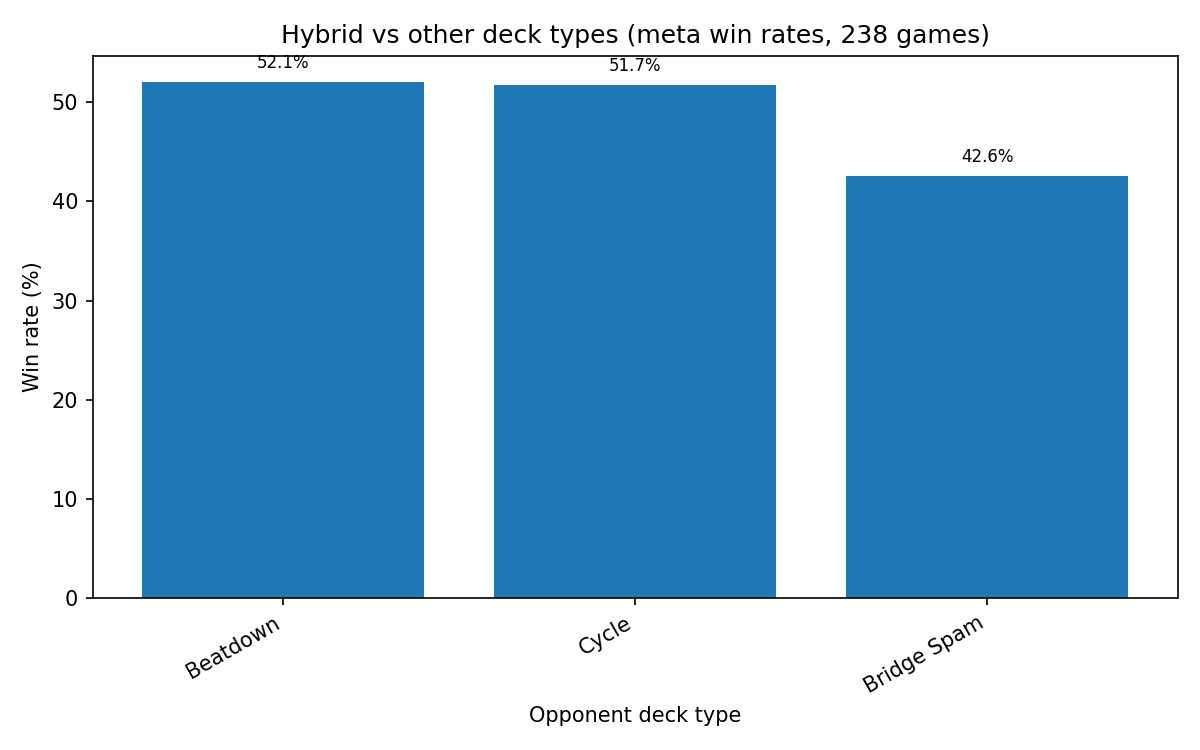


meta_matchups_siege.png


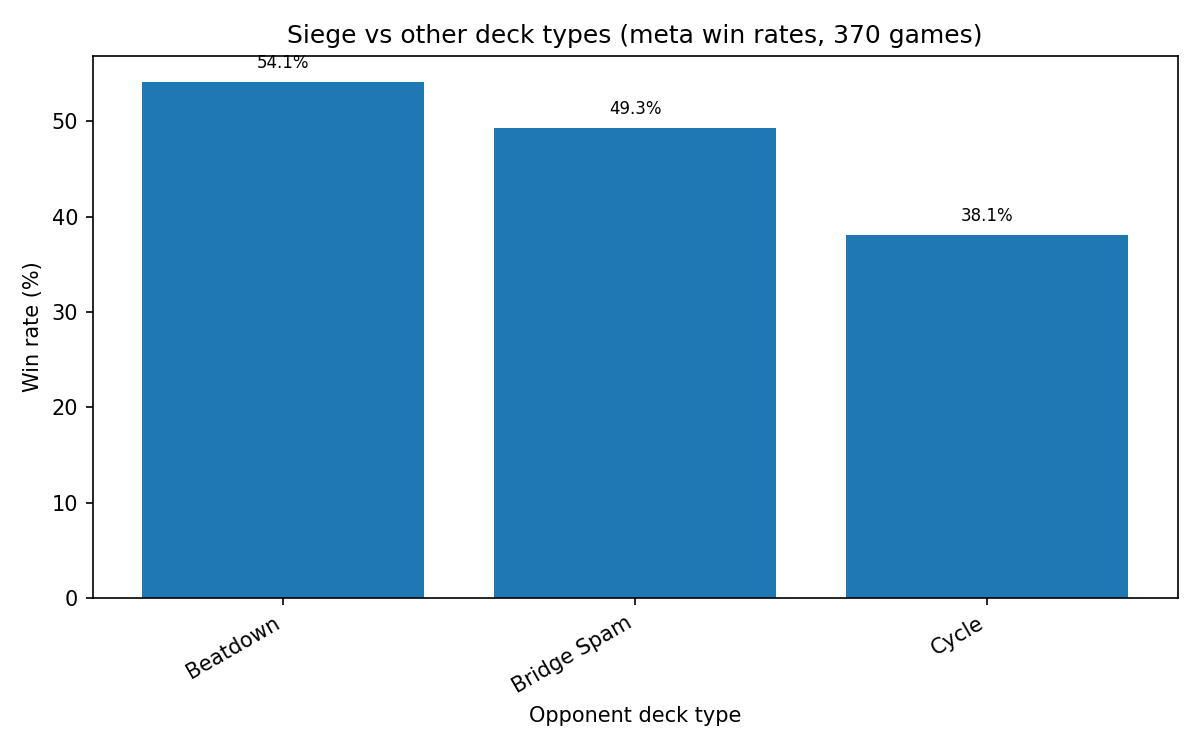


   Phase 1: User plots

user_best_cards.png


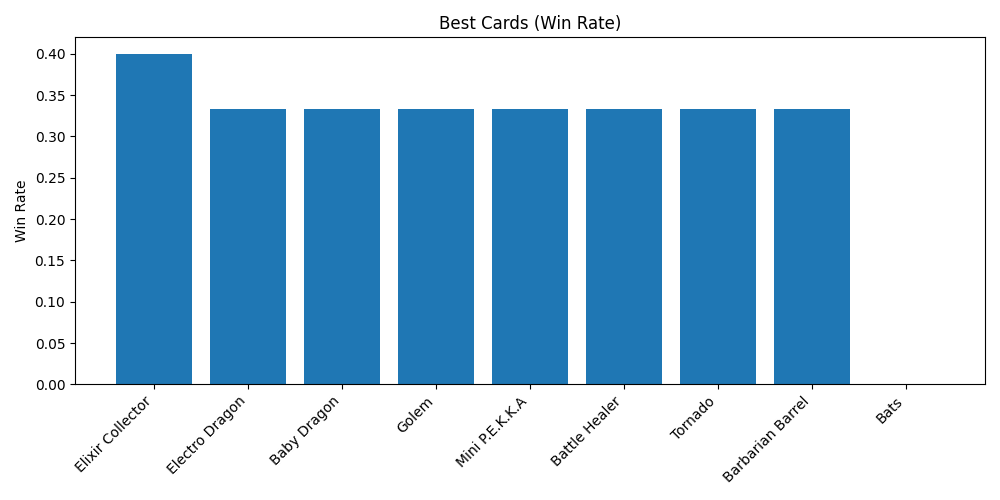


user_easy_opp_cards.png


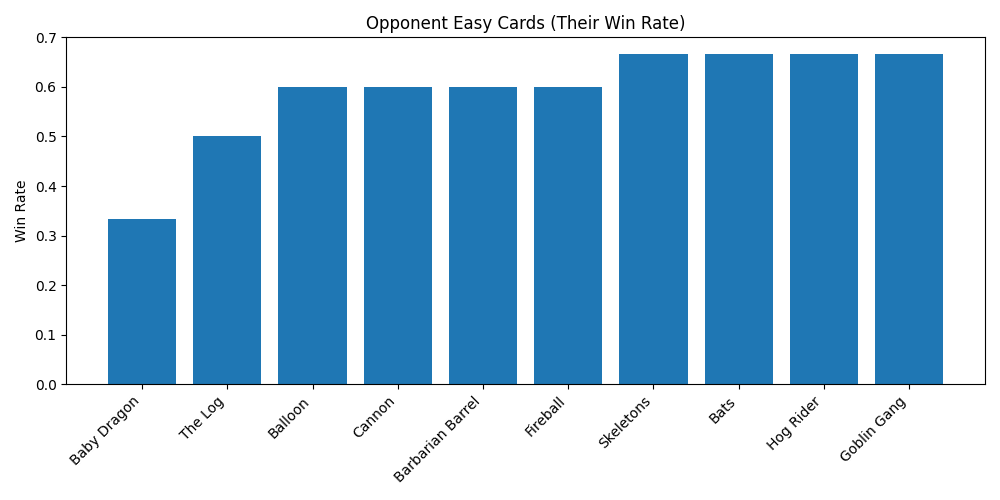


user_my_deck_types.png


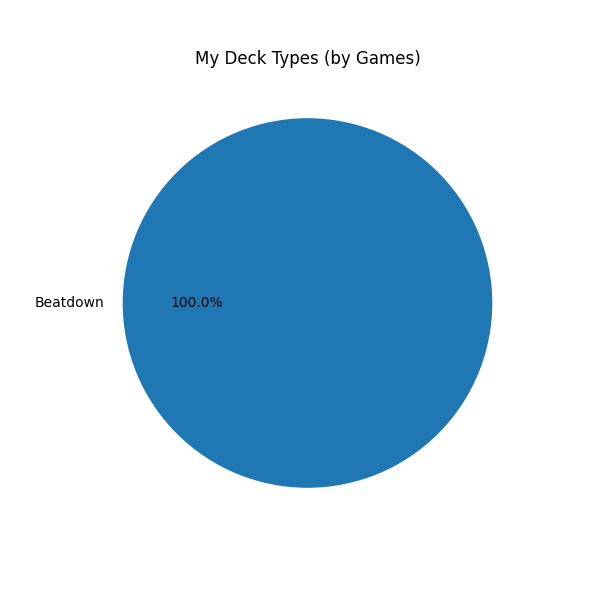


user_opp_deck_types_bar.png


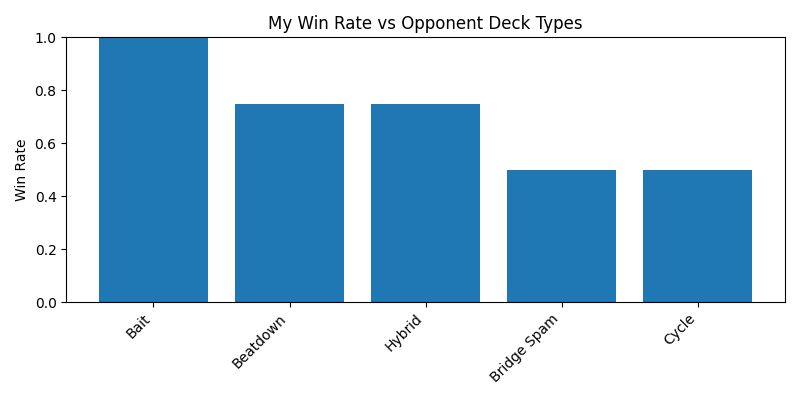


user_opp_deck_types.png


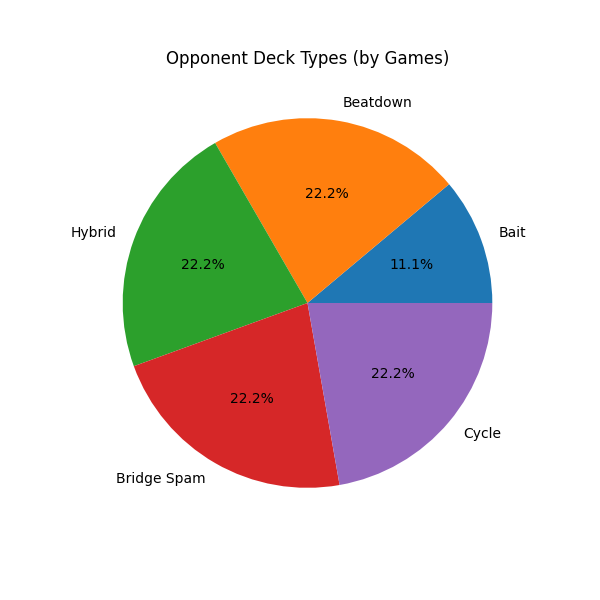


user_tough_opp_cards.png


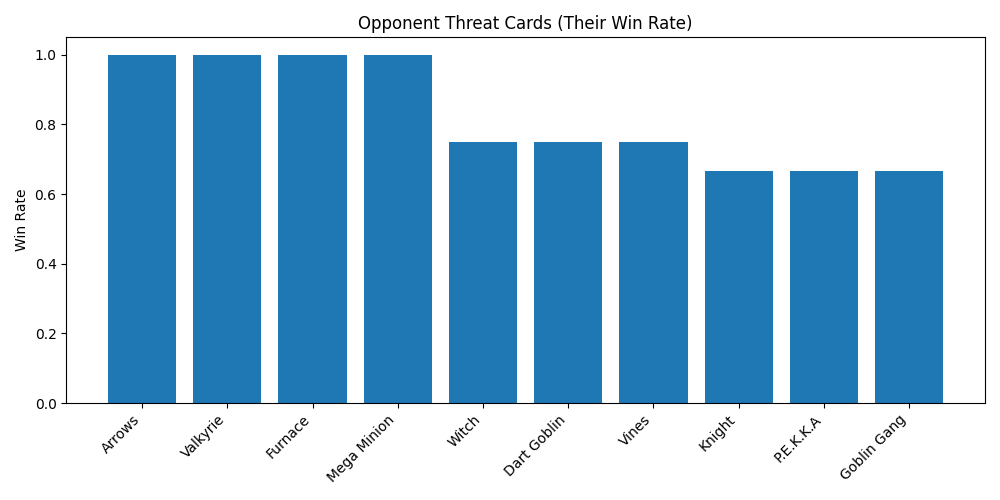


user_worst_cards.png


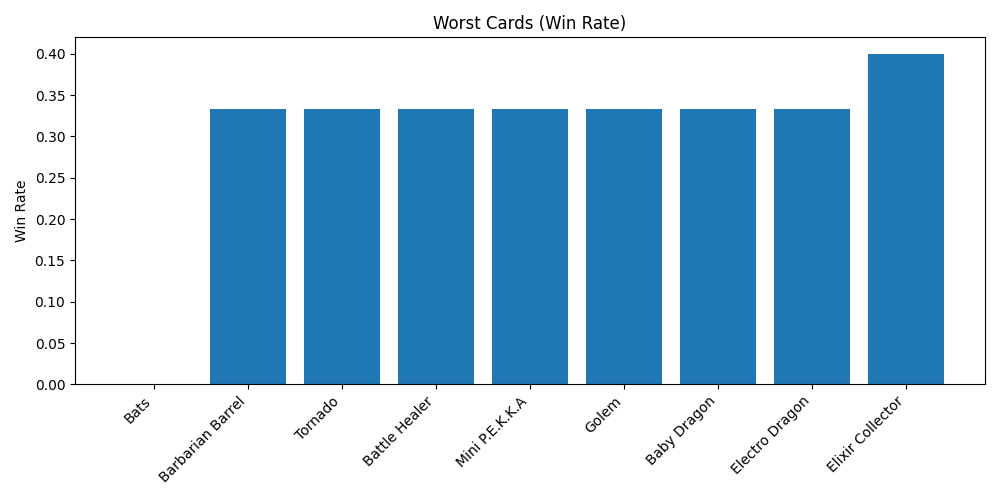

In [5]:
from pathlib import Path
from IPython.display import display, Image

PLOTS_DIR = Path("plots")

def show_named_plots(title: str, filenames: list[str], width: int = 650):
    """Display plots cleanly resized so the notebook looks good."""
    print(f"\n============================")
    print(f"   {title}")
    print(f"============================")

    if not PLOTS_DIR.exists():
        print(f"No '{PLOTS_DIR}' folder found.")
        return

    for fname in filenames:
        full_path = PLOTS_DIR / fname
        print(f"\n{fname}")
        if full_path.exists():
            display(Image(filename=str(full_path), width=width))
        else:
            print(f"[Missing] {full_path}")

# --- Phase 0: Meta plots ---
meta_plot_files = [
    "meta_deck_types_winrate.png",
    "meta_deck_types.png",
    "meta_matchups_bait.png",
    "meta_matchups_beatdown.png",
    "meta_matchups_bridge_spam.png",
    "meta_matchups_cycle.png",
    "meta_matchups_hybrid.png",
    "meta_matchups_siege.png",
]

show_named_plots("Phase 0: Meta plots", meta_plot_files)

# --- Phase 1: User plots ---
user_plot_files = [
    "user_best_cards.png",
    "user_easy_opp_cards.png",
    "user_my_deck_types.png",
    "user_opp_deck_types_bar.png",
    "user_opp_deck_types.png",
    "user_tough_opp_cards.png",
    "user_worst_cards.png",
]

show_named_plots("Phase 1: User plots", user_plot_files)


In [7]:
#Build Phase 2 Q&A graph

print("=== BUILDING PHASE 2 Q&A GRAPH ===")
qna_graph = build_qna_graph()
print("Q&A graph ready.")


=== BUILDING PHASE 2 Q&A GRAPH ===
Q&A graph ready.


In [9]:
# Cell 5: interactive Q&A loop (uses cached meta_state & user_state)

def ask_once(question: str):
    """Helper to run a single Q&A turn through the Phase 2 graph."""
    qna_input = {
        "user_tag": user_state.get("player_tag"),
        "question": question,
        "user_analytics": user_state.get("user_analytics", {}),
        "user_llm_tables": user_state.get("user_llm_tables", {}),
        "meta_analytics": meta_state.get("meta_analytics", {}),
        "meta_llm_tables": meta_state.get("meta_llm_tables", {}),
        "meta_table": meta_state.get("meta_table", []),
        "notes": [],
    }

    qna_state = qna_graph.invoke(qna_input)

    # Pull out values to display
    question_text = qna_state.get("question", "")
    category = qna_state.get("question_category", "unknown")
    context_text = qna_state.get("context_text", "").strip()
    answer = qna_state.get("answer", "(no answer)")
    notes = qna_state.get("notes", [])

    # USER-FRIENDLY CLEAN OUTPUT
    print(f"\n[Question]\n{question_text}")
    print(f"\n[Category]\n{category}")

    if context_text:
        print(f"\n[Context text]\n{context_text}")

    print("\n=== ANSWER ===\n")
    print(answer)

    # Keep only short internal trace
    print("\n[Last notes]")
    for line in notes[-5:]:
        print(" •", line)


# Simple REPL-style loop
while True:
    q = input("\nAsk a Clash question (or type 'quit' to exit):\n> ").strip()
    if q.lower() in {"quit", "exit"}:
        print("Goodbye!")
        break

    ask_once(q)



Ask a Clash question (or type 'quit' to exit):
>  what decks are meta right now?



[Question]
what decks are meta right now?

[Category]
meta

[Context text]
Meta deck performance table included.

=== ANSWER ===

Currently, the most meta decks in Clash Royale are Cycle, Bridge Spam, and Beatdown. Cycle decks have the largest meta share at about 37%, with a solid win rate just over 51%. They are popular because they cycle quickly through cards to apply constant pressure or control the game tempo. Beatdown decks follow closely with nearly 20% meta share and a slightly higher win rate approaching 52%, relying on heavy troops to do sustained damage. Bridge Spam decks are also significant, making up roughly 20% of matches, although their win rate is a bit below 49%.

Siege, Hybrid, and Bait decks make up smaller portions of the meta, ranging from about 6% to 10% each, with win rates generally below 50%. This suggests they are less favored or less effective in the current environment.

For success, focusing on a Cycle or Beatdown deck could be your best bet given their st


Ask a Clash question (or type 'quit' to exit):
>  what deck do I lost to the most?



[Question]
what deck do I lost to the most?

[Category]
user

[Context text]
User overall stats are included (games, wins, losses, win rate).
User has matchup stats vs 5 archetypes showing win/loss rates by deck type.
Meta deck summary is available for 6 archetypes (games, win rate, meta share).
Meta matchup summary is available for 28 archetype pairs (attacker vs defender win rates).

=== ANSWER ===

Based on your recent 18 ranked games, you lost the most against Bait decks, with a 0% win rate in 2 games (0 wins and 2 losses). This is your toughest matchup, followed by Hybrid and Beatdown matchups, where your win rates are 25% each. In contrast, you have a more balanced 50% win rate versus Bridge Spam and Cycle decks.

Your overall win rate is 33%, which is below average, likely impacted by difficulties against Bait and Hybrid decks. Since these matchups heavily affect your record, focusing on improving your defenses against Bait is key. Bait decks aim to overwhelm opponents with mul


Ask a Clash question (or type 'quit' to exit):
>  quit


Goodbye!


In [ ]:
what deck do I lost to the most?